In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time
import winsound

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from keras.optimizers import Adam

In [2]:
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

[]


In [3]:
# tf.random.set_seed(42)

base_path = 'dataset/'
train_dir = os.path.join(base_path, 'train')

train_csv = os.path.join(base_path, 'train', '_annotations.csv')
valid_csv = os.path.join(base_path, 'valid', '_annotations.csv')
test_csv = os.path.join(base_path, 'test', '_annotations.csv')
                        
# Function to load and preprocess images
def load_and_preprocess_image(filename, label, bbox):
    try:
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [360, 360])  # VGG16 input size
        img = tf.cast(img, tf.float32)  / 255.0
        #img = tf.keras.applications.vgg16.preprocess_input(img)
        return img, label, bbox
    except tf.errors.NotFoundError:
        print(f"File not found: {filename}")
        return None, None, None


In [4]:
    
# Function to load data from CSV and create a dataset
def create_dataset(csv_file,base_dir, is_training=True):
    df = pd.read_csv(csv_file)
    unique_labels = df['class'].unique()
    print(unique_labels)
    # Encode class labels
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])

    filenames = df['filename'].apply(lambda x: os.path.join(base_dir, x)).values
    labels = df['class'].values


    bboxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values
    
    #print(f"filename:{filenames}")
    print(f"Base Dir: {base_dir}")
    print(f"Labels shape: {labels.shape}")
    print(f"Bounding boxes shape: {bboxes.shape}")
    print(len(le.classes_))
    
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels, bboxes))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda x, y, z: x is not None)  # Filter out None values
 
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset, le

# Create datasets one by one for train , valid , test
train_dataset, label_encoder = create_dataset(train_csv, os.path.join(base_path, 'train'))
valid_dataset, _ = create_dataset(valid_csv, os.path.join(base_path, 'valid'), is_training=False)
test_dataset, _ = create_dataset(test_csv, os.path.join(base_path, 'test'), is_training=False)

['SMG' 'ShotGun' 'HandGun' 'Rifle']
Base Dir: dataset/train
Labels shape: (3200,)
Bounding boxes shape: (3200, 4)
4
['HandGun' 'Rifle' 'ShotGun' 'SMG']
Base Dir: dataset/valid
Labels shape: (819,)
Bounding boxes shape: (819, 4)
4
['SMG' 'ShotGun' 'HandGun' 'Rifle']
Base Dir: dataset/test
Labels shape: (467,)
Bounding boxes shape: (467, 4)
4


In [5]:
# Create a custom VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(360, 360, 3))
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Input layer
inputs = Input(shape=(360, 360, 3))

# VGG16 base model
x = base_model(inputs, training=True)

# Global average pooling
x = GlobalAveragePooling2D()(x)

# Additional fully connected layers to extend the model to 25 layers

# Layer 17: Fully Connected Layer 1 with Batch Normalization
x = Dense(512)(x)
x = BatchNormalization()(x)  # Batch normalization to stabilize training
x = LeakyReLU(negative_slope=0.1)(x)  # Leaky ReLU for better performance
x = Dropout(0.5)(x)  # Higher dropout to reduce overfitting

# Layer 18: Fully Connected Layer 2
x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.5)(x)

# Layer 19: Fully Connected Layer 3
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.4)(x)

# Layer 20: Fully Connected Layer 4
x = Dense(64)(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Output layers
# Layer 24: Output layer for class predictions
class_output = Dense(4, activation='softmax', name='class_output')(x)

# Layer 25: Output layer for bounding box regression
bbox_output = Dense(4, name='bbox_output')(x)

# Create the final model
model = Model(inputs=inputs, outputs=[class_output, bbox_output])

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
              metrics={'class_output': 'accuracy','bbox_output': 'mae'})

# Summary of the model (to check number of layers)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 11, 11,    │ 14,714,688 │ input_layer_1[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    262,656 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 512)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 4)         │        260 │ leaky_re_lu_3[0]… │
│ (Dense)             │                   │            │                 

 Total params: 15,154,184 (57.81 MB)

 Trainable params: 7,517,000 (28.68 MB)

 Non-trainable params: 7,637,184 (29.13 MB)

In [6]:
for batch in train_dataset.take(1):
    print(f"Batch shapes: {[x.shape for x in batch]}")

# Check data shapes
for batch in train_dataset.take(2):
    images, labels, bboxes = batch
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    print(f"Batch bounding boxes shape: {bboxes.shape}")

Batch shapes: [TensorShape([32, 360, 360, 3]), TensorShape([32]), TensorShape([32, 4])]
Batch images shape: (32, 360, 360, 3)
Batch labels shape: (32,)
Batch bounding boxes shape: (32, 4)
Batch images shape: (32, 360, 360, 3)
Batch labels shape: (32,)
Batch bounding boxes shape: (32, 4)


In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [8]:

def train_step(images, labels, bboxes):
    with tf.GradientTape() as tape:
        class_predictions, bbox_predictions = model(images, training=True)
        class_loss = tf.keras.losses.sparse_categorical_crossentropy(labels, class_predictions)
        bbox_loss = tf.keras.losses.MeanSquaredError()(bboxes, bbox_predictions)  # Corrected
        total_loss = tf.reduce_mean(tf.cast(class_loss, tf.float32)) + tf.reduce_mean(tf.cast(bbox_loss, tf.float32))
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

def validation_step(images, labels, bboxes):
    predictions = model(images, training=False)
    class_predictions, bbox_predictions = predictions
    class_loss = tf.keras.losses.sparse_categorical_crossentropy(labels, class_predictions)
    bbox_loss = tf.keras.losses.MeanSquaredError()(bboxes, bbox_predictions)
    total_loss = tf.reduce_mean(class_loss) + tf.reduce_mean(bbox_loss)
    return total_loss

In [9]:
initial_epoch = 0
# Load the latest checkpoint (if any)
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print(f"Restored from {checkpoint_manager.latest_checkpoint}")
else:
    print("Starting from scratch.")


Starting from scratch.


In [10]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

num_epochs = 10  # Set your number of epochs
for epoch in range(initial_epoch,num_epochs):
    start_time = time.time()
    print(f'Epoch {epoch + 1}/{num_epochs}')
    epoch_loss = 0
    train_accuracy.reset_state()

    # Training
    for batch in train_dataset:
        images, labels, bboxes = batch
        batch_loss = train_step(images, labels, bboxes)
        epoch_loss += batch_loss
        train_accuracy.update_state(labels, model(images, training=True)[0])

    # Validation
    val_loss = 0
    val_accuracy.reset_state()
    for batch1 in valid_dataset:
        images, labels, bboxes = batch1
        batch_val_loss = validation_step(images, labels, bboxes)
        val_loss += batch_val_loss
        val_accuracy.update_state(labels, model(images, training=False)[0])

    elapsed_time = time.time() - start_time

    #print(f'Epoch {epoch + 1} - Loss: {epoch_loss.numpy()} - Validation Loss: {val_loss.numpy()}')
    print(f'Epoch {epoch + 1} - Loss: {epoch_loss.numpy():.4f} - Validation Loss: {val_loss.numpy():.4f}')
    print(f'Train Accuracy: {train_accuracy.result().numpy():.4f} - Validation Accuracy: {val_accuracy.result().numpy():.4f}')
    print(f'Time for epoch {epoch + 1}: {elapsed_time:.2f} seconds\n')
    epoch_info = (
        f'Epoch {epoch + 1} - Loss: {epoch_loss.numpy():.4f} - '
        f'Validation Loss: {val_loss.numpy():.4f}\n'
        f'Train Accuracy: {train_accuracy.result().numpy():.4f} - '
        f'Validation Accuracy: {val_accuracy.result().numpy():.4f}\n'
        f'Time for epoch {epoch + 1}: {elapsed_time:.2f} seconds\n'
        f'Checkpoint saved for epoch {epoch + 1}\n\n'
    )

    # Print to console (optional)
    # print(epoch_info)

    # Write to the file
    with open('epochsdataCustom.txt', 'a') as file:
        file.write(epoch_info)

    # Save the model's weights after each epoch
    checkpoint_manager.save()
    print(f"Checkpoint saved for epoch {epoch + 1}\n")
    
    # After the process finishes+
    duration = 1000  # milliseconds
    freq = 440  # Hz
    winsound.Beep(freq, duration)

Epoch 1/10
Epoch 1 - Loss: 4705721.0000 - Validation Loss: 1244511.1250
Train Accuracy: 0.2447 - Validation Accuracy: 0.1954
Time for epoch 1: 9155.43 seconds

Checkpoint saved for epoch 1

Epoch 2/10
Epoch 2 - Loss: 4692543.5000 - Validation Loss: 1240230.7500
Train Accuracy: 0.2578 - Validation Accuracy: 0.2308
Time for epoch 2: 7833.25 seconds

Checkpoint saved for epoch 2

Epoch 3/10
Epoch 3 - Loss: 4679639.0000 - Validation Loss: 1238508.6250
Train Accuracy: 0.2622 - Validation Accuracy: 0.2821
Time for epoch 3: 9356.67 seconds

Checkpoint saved for epoch 3

Epoch 4/10
Epoch 4 - Loss: 4667161.5000 - Validation Loss: 1234654.1250
Train Accuracy: 0.2725 - Validation Accuracy: 0.2967
Time for epoch 4: 10489.04 seconds

Checkpoint saved for epoch 4

Epoch 5/10
Epoch 5 - Loss: 4654250.5000 - Validation Loss: 1226887.3750
Train Accuracy: 0.2894 - Validation Accuracy: 0.2442
Time for epoch 5: 8738.05 seconds

Checkpoint saved for epoch 5

Epoch 6/10
Epoch 6 - Loss: 4640893.5000 - Validat

In [11]:
# Evaluate on test dataset
test_loss = 0
for batch in test_dataset:
    images, labels, bboxes = batch
    batch_test_loss = validation_step(images, labels, bboxes)  # You can reuse validation_step here
    test_loss += batch_test_loss

print(f'Test Loss: {test_loss.numpy()}')

Test Loss: 698841.375


In [3]:
model.save('model/modelCustom.keras')

NameError: name 'model' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


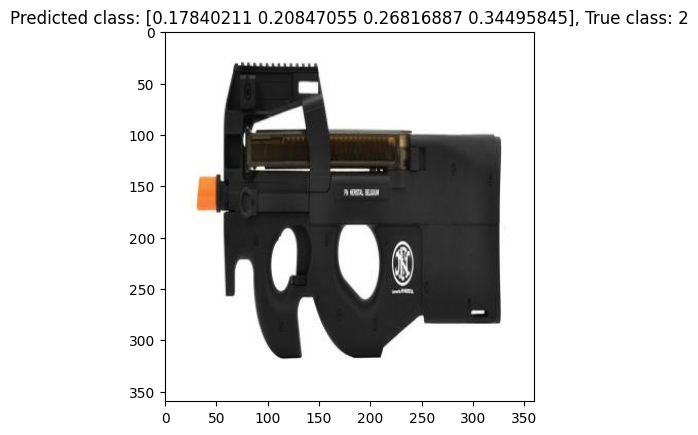

In [13]:
for batch in test_dataset.take(1):  # Take one batch of images
    images, labels, bboxes = batch
    pred_class, pred_bboxes = model.predict(images)
    
    # Display one example
    plt.imshow(images[0])
    plt.title(f'Predicted class: {pred_class[0]}, True class: {labels[0]}')
    plt.show()

In [14]:
# For classification accuracy
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
for batch in test_dataset:
    images, labels, bboxes = batch
    pred_class, pred_bboxes = model(images, training=False)
    accuracy.update_state(labels, pred_class)

print(f'Test Accuracy: {accuracy.result().numpy()}')


Test Accuracy: 0.31691649556159973


In [15]:
# model.fit(
#             train_dataset,
#             validation_data=valid_dataset,
#             epochs=10,  # Adjust as needed
#             verbose=1
#         )